# 다중 변수 활용 DL 기반 판매량 예측

## 프로젝트 개요

- 프로젝트명 : 제품 판매량 예측
- 데이터 : Rossmann (Drug store)


- **과거 30일(t-30, t-29, ..., t-1) 판매량 관련 데이터를 이용하여, 이후 3일(t, t+1, t+2) 판매량 예측**
    - 4.1 Fully-connected Neural Network
    - 4.2 1-layer LSTM
    - 4.3 Multi-layer LSTM
    - 4.4 Bi-directional LSTM
    - 4.5 Seq2seq (Auto-regression LSTM)
    
    
- **과거 30일(t-30, t-29, ..., t-1) 판매량 관련 데이터를 이용하여, 다음 날(t) 판매량 예측**
    - 4.6 Dual-stage attention-based RNN(DA-RNN)

## 운영 및 개발 환경

In [1]:
import warnings
warnings.filterwarnings("ignore")
from dateutil import relativedelta
import time
import os
import sys
import gc
import datetime
import pandas as pd
import tensorflow as tf
import numpy as np
from importlib import reload
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
import matplotlib.font_manager as fm
from matplotlib import rc

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'data')
PROCESS_DIR = os.path.join(os.path.dirname(ROOT_DIR), 'data', 'processed')
PMD_DIR = os.path.join(ROOT_DIR, 'display_stand')

import preprocessing as preprocess

import core.data_prepare as prepare
from core.AutoRegressionLSTM import *
from core.train_DARNN import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
time_str = str(int(datetime.datetime.today().strftime('%Y%m%d%H%M%S')))
os.chdir(ROOT_DIR)

data_dir = os.path.join(ROOT_DIR, 'data')
data_raw_dir = os.path.join(data_dir, 'raw')
data_processed_dir = os.path.join(data_dir, 'processed')
run_dir = os.path.abspath(os.path.join(ROOT_DIR, 'run', time_str))
model_dir = os.path.join(run_dir, 'mi_lstm_month')
train_dir = os.path.join(run_dir, 'summarise', 'train')
test_dir = os.path.join(run_dir, 'test')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(data_raw_dir, exist_ok=True)
os.makedirs(data_processed_dir, exist_ok=True)
os.makedirs(run_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 주요 라이브러리

- python : 3.7
- pandas : 1.1.3
- numpy : 1.19.5
- tensorflow : 2.4.0

## 데이터 특성

- Id : an Id that represents a (Store, Date) duple within the test set
- Store : a unique Id for each store
- Sales : the turnover for any given day (this is what you are predicting)
- Customers : the number of customers on a given day
- Open : an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday : indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday : indicates if the (Store, Date) was affected by the closure of public schools
- Promo : indicates whether a store is running a promo on that day

# 데이터 파일 로드

In [3]:
# Load Data file
df = pd.read_csv(os.path.join(data_raw_dir, 'train.csv'))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [6]:
df = df.loc[df['Store']==1,:].reset_index()
df = df.drop(['index', 'Store'], axis=1)
df['StateHoliday'] = df['StateHoliday'].astype('str')

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df = df[['Date', 'Sales', 'Customers', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']]

In [9]:
df = pd.get_dummies(df, columns = ['DayOfWeek'], dtype='int64')
df = pd.get_dummies(df, columns = ['StateHoliday'], dtype='int64')

In [10]:
df = df.sort_values(by='Date').reset_index(drop=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            942 non-null    datetime64[ns]
 1   Sales           942 non-null    int64         
 2   Customers       942 non-null    int64         
 3   Open            942 non-null    int64         
 4   Promo           942 non-null    int64         
 5   SchoolHoliday   942 non-null    int64         
 6   DayOfWeek_1     942 non-null    int64         
 7   DayOfWeek_2     942 non-null    int64         
 8   DayOfWeek_3     942 non-null    int64         
 9   DayOfWeek_4     942 non-null    int64         
 10  DayOfWeek_5     942 non-null    int64         
 11  DayOfWeek_6     942 non-null    int64         
 12  DayOfWeek_7     942 non-null    int64         
 13  StateHoliday_0  942 non-null    int64         
 14  StateHoliday_a  942 non-null    int64         
 15  StateH

# 데이터 전처리

In [12]:
df.columns

Index(['Date', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'],
      dtype='object')

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler_y = MinMaxScaler(feature_range=(-1, 1))
df_y_scaled = scaler_y.fit_transform(df[['Sales']]).reshape(-1,1)

scaler_x = MinMaxScaler(feature_range=(-1, 1))
df_x_scaled = scaler_x.fit_transform(np.array(df[['Customers', 'Open', 'Promo', 'SchoolHoliday',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']]))

In [14]:
df_y_scaled = pd.DataFrame(df_y_scaled, columns=['Sales'])
df_x_scaled = pd.DataFrame(df_x_scaled, columns=['Customers', 'Open', 'Promo', 'SchoolHoliday',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'])

In [15]:
df = pd.concat([df['Date'], df_y_scaled, df_x_scaled], axis=1)

In [16]:
df_train = df[df['Date']<'2015-01-01'].reset_index(drop=True)
df_test = df[df['Date']>='2015-01-01'].reset_index(drop=True)

In [17]:
df_train.shape
df_test.shape

(730, 17)

(212, 17)

In [18]:
target_size = 3  # coming number of days

In [19]:
def make_dataset(sales_data):
    maxday = 30   # x 값으로 볼 time series 길이
    maxtarget = 3  # y 값으로 볼 time series 길이
    dataset = []

    for i in range(maxday, len(sales_data) - maxtarget+1):
        print('making dataset progress : {}/{}'.format(i, len(sales_data)), end='\r')

        historySet = sales_data.Sales.loc[i - maxday:i - 1]
        targetSet = sales_data.Sales.loc[i:i + maxtarget - 1]
        
        CustomersSet = sales_data.Customers.loc[i - maxday:i - 1]
        OpenSet = sales_data.Open.loc[i - maxday:i - 1]
        PromoSet = sales_data.Promo.loc[i - maxday:i - 1]
        SchoolHolidaySet = sales_data.SchoolHoliday.loc[i - maxday:i - 1]
        DayOfWeek_1Set = sales_data.DayOfWeek_1.loc[i - maxday:i - 1]
        DayOfWeek_2Set = sales_data.DayOfWeek_2.loc[i - maxday:i - 1]
        DayOfWeek_3Set = sales_data.DayOfWeek_3.loc[i - maxday:i - 1]
        DayOfWeek_4Set = sales_data.DayOfWeek_4.loc[i - maxday:i - 1]
        DayOfWeek_5Set = sales_data.DayOfWeek_5.loc[i - maxday:i - 1]
        DayOfWeek_6Set = sales_data.DayOfWeek_6.loc[i - maxday:i - 1]
        DayOfWeek_7Set = sales_data.DayOfWeek_7.loc[i - maxday:i - 1]     
        StateHoliday_0Set = sales_data.StateHoliday_0.loc[i - maxday:i - 1]
        StateHoliday_aSet = sales_data.StateHoliday_a.loc[i - maxday:i - 1]
        StateHoliday_bSet = sales_data.StateHoliday_b.loc[i - maxday:i - 1]
        StateHoliday_cSet = sales_data.StateHoliday_c.loc[i - maxday:i - 1]
        
        target_history = np.reshape(np.array(historySet), (maxday, 1))
        target_sales = np.reshape(np.array(targetSet), (maxtarget, 1))
        CustomersSet_history = np.reshape(np.array(CustomersSet), (maxday, 1))
        OpenSet_history = np.reshape(np.array(OpenSet), (maxday, 1))
        PromoSet_history = np.reshape(np.array(PromoSet), (maxday, 1))
        SchoolHolidaySet_history = np.reshape(np.array(SchoolHolidaySet), (maxday, 1))
        DayOfWeek_1Set_history = np.reshape(np.array(DayOfWeek_1Set), (maxday, 1))
        DayOfWeek_2Set_history = np.reshape(np.array(DayOfWeek_2Set), (maxday, 1))
        DayOfWeek_3Set_history = np.reshape(np.array(DayOfWeek_3Set), (maxday, 1))
        DayOfWeek_4Set_history = np.reshape(np.array(DayOfWeek_4Set), (maxday, 1))
        DayOfWeek_5Set_history = np.reshape(np.array(DayOfWeek_5Set), (maxday, 1))
        DayOfWeek_6Set_history = np.reshape(np.array(DayOfWeek_6Set), (maxday, 1))
        DayOfWeek_7Set_history = np.reshape(np.array(DayOfWeek_7Set), (maxday, 1))
        StateHoliday_0Set_history = np.reshape(np.array(StateHoliday_0Set), (maxday, 1))
        StateHoliday_aSet_history = np.reshape(np.array(StateHoliday_aSet), (maxday, 1))
        StateHoliday_bSet_history = np.reshape(np.array(StateHoliday_bSet), (maxday, 1))
        StateHoliday_cSet_history = np.reshape(np.array(StateHoliday_cSet), (maxday, 1))
                
        dataset.append(
            {'target_history': target_history,
                 'CustomersSet_history': CustomersSet_history,
                 'OpenSet_history': OpenSet_history,
             'PromoSet_history': PromoSet_history,
            'SchoolHolidaySet_history': SchoolHolidaySet_history,
            'DayOfWeek_1Set_history': DayOfWeek_1Set_history,
            'DayOfWeek_2Set_history': DayOfWeek_2Set_history,
            'DayOfWeek_3Set_history': DayOfWeek_3Set_history,
            'DayOfWeek_4Set_history': DayOfWeek_4Set_history,
            'DayOfWeek_5Set_history': DayOfWeek_5Set_history,
            'DayOfWeek_6Set_history': DayOfWeek_6Set_history,
            'DayOfWeek_7Set_history': DayOfWeek_7Set_history,
            'StateHoliday_0Set_history': StateHoliday_0Set_history,
            'StateHoliday_aSet_history': StateHoliday_aSet_history,
            'StateHoliday_bSet_history': StateHoliday_bSet_history,
            'StateHoliday_cSet_history': StateHoliday_cSet_history,
                 'target_sales': target_sales,
            })
    return dataset

In [20]:
dataset_train = make_dataset(df_train)
dataset_test = make_dataset(df_test)

In [21]:
def DataBatch(dataset):
    maxday = 30   # x 값으로 볼 time series 길이
    maxtarget = 3  # y 값으로 볼 time series 길이
    
    y = []
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []
    x6 = []
    x7 = []
    x8 = []
    x9 = []
    x10 = []
    x11 = []
    x12 = []
    x13 = []
    x14 = []
    x15 = []
    target = []
    
    for d in dataset:
        y.append(d['target_history'])
        x1.append(d['CustomersSet_history'])
        x2.append(d['OpenSet_history'])
        x3.append(d['PromoSet_history'])
        x4.append(d['SchoolHolidaySet_history'])
        x5.append(d['DayOfWeek_1Set_history'])
        x6.append(d['DayOfWeek_2Set_history'])
        x7.append(d['DayOfWeek_3Set_history'])
        x8.append(d['DayOfWeek_4Set_history'])
        x9.append(d['DayOfWeek_5Set_history'])
        x10.append(d['DayOfWeek_6Set_history'])
        x11.append(d['DayOfWeek_7Set_history'])
        x12.append(d['StateHoliday_0Set_history'])
        x13.append(d['StateHoliday_aSet_history'])
        x14.append(d['StateHoliday_bSet_history'])
        x15.append(d['StateHoliday_cSet_history'])
        target.append(d['target_sales'])
    
    y = np.reshape(y, (-1, maxday, 1))  # (# of batch_size(window에 따라 데이터 뽑았을 때 데이터 갯수), time_size, # of feature(=1))
    x1 = np.reshape(x1, (-1, maxday, 1))
    x2 = np.reshape(x2, (-1, maxday, 1))
    x3 = np.reshape(x3, (-1, maxday, 1))
    x4 = np.reshape(x4, (-1, maxday, 1))
    x5 = np.reshape(x5, (-1, maxday, 1))
    x6 = np.reshape(x6, (-1, maxday, 1))
    x7 = np.reshape(x7, (-1, maxday, 1))
    x8 = np.reshape(x8, (-1, maxday, 1))
    x9 = np.reshape(x9, (-1, maxday, 1))
    x10 = np.reshape(x10, (-1, maxday, 1))
    x11 = np.reshape(x11, (-1, maxday, 1))
    x12 = np.reshape(x12, (-1, maxday, 1))
    x13 = np.reshape(x13, (-1, maxday, 1))
    x14 = np.reshape(x14, (-1, maxday, 1))
    x15 = np.reshape(x15, (-1, maxday, 1))
    target = np.reshape(target, (-1, maxtarget, 1))
    
    x_trainFinal = np.reshape(np.stack((y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15), axis=2), (-1, maxday, 16))
    y_trainFinal = target
   
    return x_trainFinal, y_trainFinal

In [22]:
X_train, Y_train = DataBatch(dataset_train)
X_test, Y_test = DataBatch(dataset_test)

In [23]:
X_train.shape
Y_train.shape
X_test.shape
Y_test.shape

(698, 30, 16)

(698, 3, 1)

(180, 30, 16)

(180, 3, 1)

# 모델 훈련 및 평가

- Output : Sales (t, t+1, t+2)
- Input : Sales, Customers, Open, Promo, SchoolHoliday, DayOfWeek_1, DayOfWeek_2, DayOfWeek_3, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6, DayOfWeek_7, StateHoliday_0, StateHoliday_a, StateHoliday_b, StateHoliday_c (t-30, t-29, ..., t-1)


- 평가 : Mean Absolute Error
    - 3일간의 Sales 합 (발주량 예측)

## Fully-connected Neural Network

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    # Shape: (time, features) => (time*features)
    keras.layers.Flatten(input_shape=[30, 16]), 
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='linear')
])

epochs = 30
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=30, validation_data=(X_test, Y_test))

Train on 698 samples, validate on 180 samples
Epoch 1/30
698/698 [==============================] - 2s 4ms/sample - loss: 0.5157 - val_loss: 0.1797
Epoch 2/30
698/698 [==============================] - 0s 258us/sample - loss: 0.1390 - val_loss: 0.1214
Epoch 3/30
698/698 [==============================] - 0s 274us/sample - loss: 0.1038 - val_loss: 0.1433
Epoch 4/30
698/698 [==============================] - 0s 393us/sample - loss: 0.0848 - val_loss: 0.1372
Epoch 5/30
698/698 [==============================] - 0s 442us/sample - loss: 0.0792 - val_loss: 0.0696
Epoch 6/30
698/698 [==============================] - 0s 369us/sample - loss: 0.0746 - val_loss: 0.0654
Epoch 7/30
698/698 [==============================] - 0s 301us/sample - loss: 0.0667 - val_loss: 0.0674
Epoch 8/30
698/698 [==============================] - 0s 323us/sample - loss: 0.0685 - val_loss: 0.0581
Epoch 9/30
698/698 [==============================] - 0s 348us/sample - loss: 0.0583 - val_loss: 0.0505
Epoch 10/30
698/698 

In [25]:
model.evaluate(X_test, Y_test)

180/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.051312416791915894

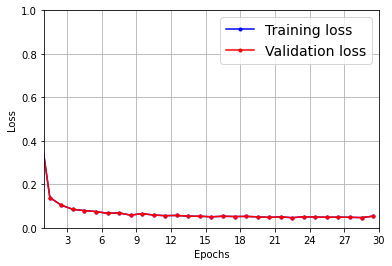

In [26]:
plot_learning_curves(history.history["loss"], history.history["val_loss"], epochs)
plt.show()

1485.1315863715279


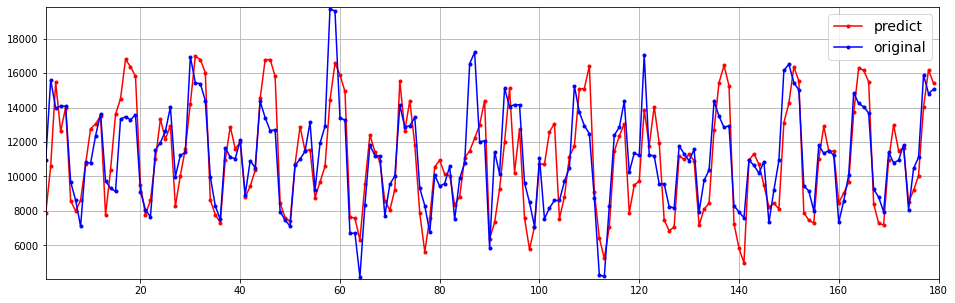

In [27]:
mae = GetResult_inverseTransfrom(X_test, Y_test, scaler_y, model, target_size)

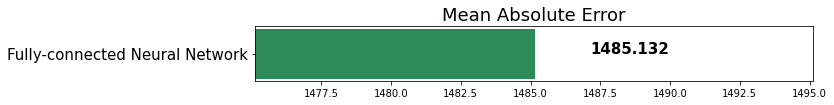

In [28]:
Graph_Evaluation(mae, 'Fully-connected Neural Network')

## 1-layer LSTM

In [29]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(64), input_shape=[None, 16]),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(16, activation='tanh'),
    keras.layers.Dense(3, activation='linear')
])

epochs=20
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, Y_train, batch_size=30, epochs=epochs, validation_data=(X_test, Y_test))

Train on 698 samples, validate on 180 samples
Epoch 1/20
698/698 [==============================] - 5s 7ms/sample - loss: 0.1597 - val_loss: 0.0790
Epoch 2/20
698/698 [==============================] - 2s 3ms/sample - loss: 0.0759 - val_loss: 0.0479
Epoch 3/20
698/698 [==============================] - 2s 3ms/sample - loss: 0.0553 - val_loss: 0.0498
Epoch 4/20
698/698 [==============================] - 2s 2ms/sample - loss: 0.0490 - val_loss: 0.0409
Epoch 5/20
698/698 [==============================] - 2s 2ms/sample - loss: 0.0472 - val_loss: 0.0554
Epoch 6/20
698/698 [==============================] - 2s 2ms/sample - loss: 0.0484 - val_loss: 0.0433
Epoch 7/20
698/698 [==============================] - 2s 2ms/sample - loss: 0.0452 - val_loss: 0.0392
Epoch 8/20
698/698 [==============================] - 2s 3ms/sample - loss: 0.0417 - val_loss: 0.0402
Epoch 9/20
698/698 [==============================] - 2s 2ms/sample - loss: 0.0405 - val_loss: 0.0410
Epoch 10/20
698/698 [===============

In [30]:
model.evaluate(X_test, Y_test)

180/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.03703027729772859

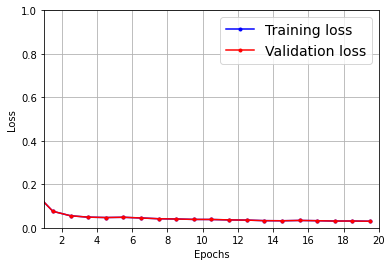

In [31]:
plot_learning_curves(history.history["loss"], history.history["val_loss"], epochs)
plt.show()

1116.4093071831596


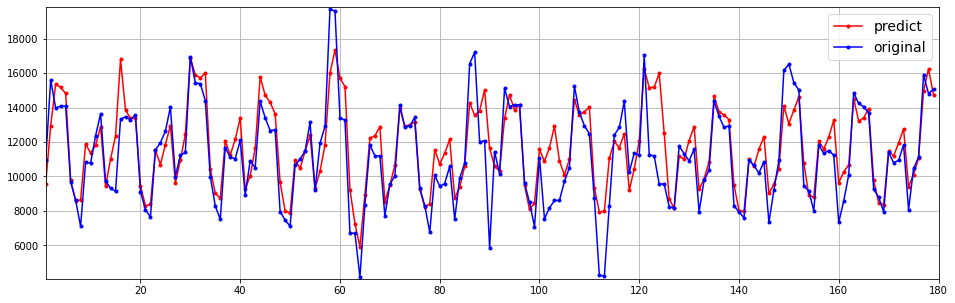

In [32]:
mae = GetResult_inverseTransfrom(X_test, Y_test, scaler_y, model, target_size)

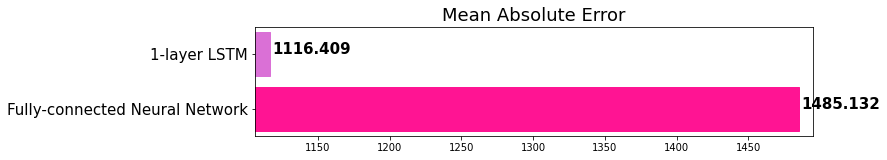

In [33]:
Graph_Evaluation(mae, '1-layer LSTM')

## Multi-layer LSTM

In [34]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(64), return_sequences=True, input_shape=[None, 16]),
    keras.layers.RNN(keras.layers.LSTMCell(32), return_sequences=True),
    # keras.layers.RNN(keras.layers.LSTMCell(16)),
    # keras.layers.RNN(keras.layers.LSTMCell(16), return_sequences=True),
    keras.layers.RNN(keras.layers.LSTMCell(12)),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(3, activation='linear')
])

epochs=40
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=30, validation_data=(X_test, Y_test))


Train on 698 samples, validate on 180 samples
Epoch 1/40
698/698 [==============================] - 12s 18ms/sample - loss: 0.1916 - val_loss: 0.1606
Epoch 2/40
698/698 [==============================] - 4s 6ms/sample - loss: 0.1832 - val_loss: 0.1528
Epoch 3/40
698/698 [==============================] - 4s 5ms/sample - loss: 0.1818 - val_loss: 0.1583
Epoch 4/40
698/698 [==============================] - 4s 5ms/sample - loss: 0.1771 - val_loss: 0.1460
Epoch 5/40
698/698 [==============================] - 4s 5ms/sample - loss: 0.1732 - val_loss: 0.1516
Epoch 6/40
698/698 [==============================] - 4s 6ms/sample - loss: 0.1704 - val_loss: 0.1392
Epoch 7/40
698/698 [==============================] - 4s 5ms/sample - loss: 0.1654 - val_loss: 0.1354
Epoch 8/40
698/698 [==============================] - 3s 5ms/sample - loss: 0.1603 - val_loss: 0.1292
Epoch 9/40
698/698 [==============================] - 4s 5ms/sample - loss: 0.1532 - val_loss: 0.1282
Epoch 10/40
698/698 [=============

In [35]:
model.evaluate(X_test, Y_test)

180/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.036448092417170605

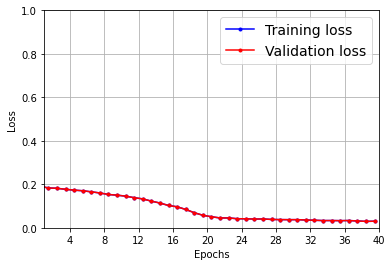

In [36]:
plot_learning_curves(history.history["loss"], history.history["val_loss"], epochs)
plt.show()

1097.8635850694445


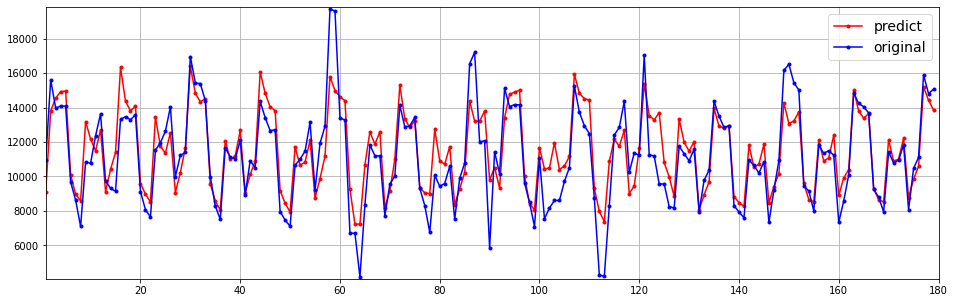

In [37]:
mae = GetResult_inverseTransfrom(X_test, Y_test, scaler_y, model, target_size)

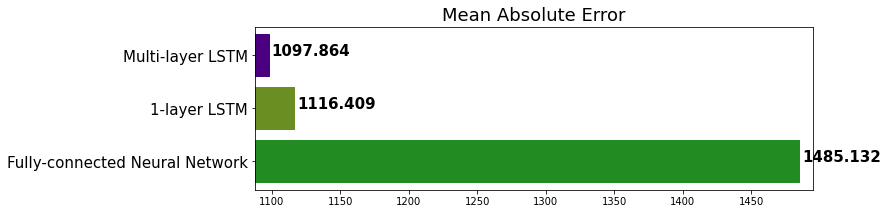

In [38]:
Graph_Evaluation(mae, 'Multi-layer LSTM')

## Bi-directional LSTM

In [39]:
model = Sequential()
model.add(Bidirectional(LSTM(32,), input_shape=(None, 16)))
model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='linear'))

epochs=40
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=30, validation_data=(X_test, Y_test))
                    # validation_data=(x_testFinal, y_testFinal))


Train on 698 samples, validate on 180 samples
Epoch 1/40
698/698 [==============================] - 8s 12ms/sample - loss: 0.2017 - val_loss: 0.1275
Epoch 2/40
698/698 [==============================] - 1s 2ms/sample - loss: 0.1360 - val_loss: 0.0905
Epoch 3/40
698/698 [==============================] - 2s 3ms/sample - loss: 0.1037 - val_loss: 0.0722
Epoch 4/40
698/698 [==============================] - 2s 2ms/sample - loss: 0.0777 - val_loss: 0.0599
Epoch 5/40
698/698 [==============================] - 2s 3ms/sample - loss: 0.0658 - val_loss: 0.0640
Epoch 6/40
698/698 [==============================] - 2s 3ms/sample - loss: 0.0595 - val_loss: 0.0472
Epoch 7/40
698/698 [==============================] - 2s 2ms/sample - loss: 0.0528 - val_loss: 0.0447
Epoch 8/40
698/698 [==============================] - 2s 3ms/sample - loss: 0.0507 - val_loss: 0.0444
Epoch 9/40
698/698 [==============================] - 2s 3ms/sample - loss: 0.0506 - val_loss: 0.0460
Epoch 10/40
698/698 [==============

In [40]:
model.evaluate(X_test, Y_test)

180/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.039782623243000775

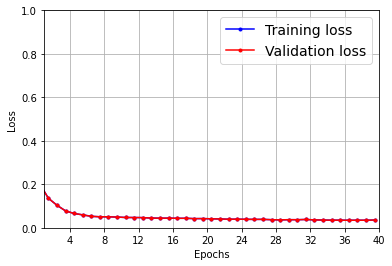

In [41]:
plot_learning_curves(history.history["loss"], history.history["val_loss"], epochs)
plt.show()

1104.209326171875


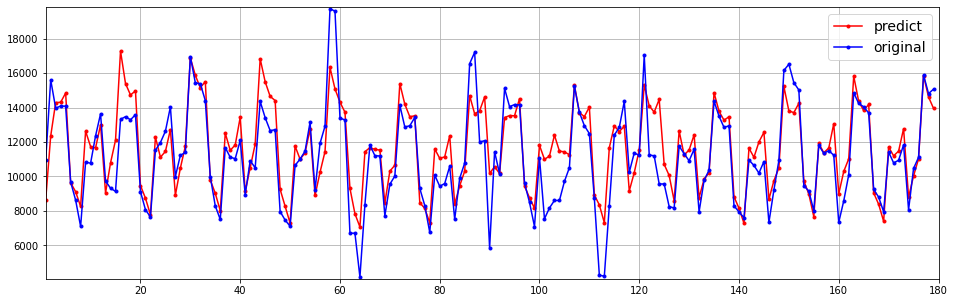

In [42]:
mae = GetResult_inverseTransfrom(X_test, Y_test, scaler_y, model, target_size)

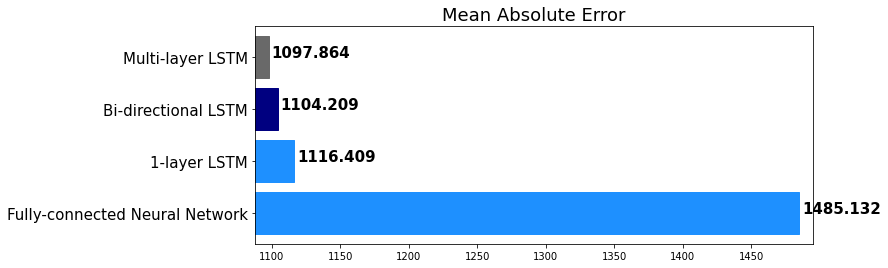

In [43]:
Graph_Evaluation(mae, 'Bi-directional LSTM')

## Seq2seq (for real value data, Auto-regression LSTM)

(Example) time_size = 24, target_size = 24
<center><img src='store_pmd/Auto-regression LSTM.png' width='500'></center>  

In [44]:
AutoRegression_model = AutoRegressionLSTM(units=32, out_steps=3)

In [45]:
epochs=50
AutoRegression_model.compile(loss="mse", optimizer="adam")
history = AutoRegression_model.fit(X_train, Y_train, epochs=epochs, batch_size=30, validation_data=(X_test, Y_test))
                    # validation_data=(x_testFinal, y_testFinal))

Train on 698 samples, validate on 180 samples
Epoch 1/50
698/698 [==============================] - 5s 8ms/sample - loss: 0.1965 - val_loss: 0.1405
Epoch 2/50
698/698 [==============================] - 1s 2ms/sample - loss: 0.1611 - val_loss: 0.1252
Epoch 3/50
698/698 [==============================] - 1s 2ms/sample - loss: 0.1422 - val_loss: 0.1193
Epoch 4/50
698/698 [==============================] - 1s 2ms/sample - loss: 0.1294 - val_loss: 0.1007
Epoch 5/50
698/698 [==============================] - 1s 2ms/sample - loss: 0.1168 - val_loss: 0.0959
Epoch 6/50
698/698 [==============================] - 1s 2ms/sample - loss: 0.1041 - val_loss: 0.0803
Epoch 7/50
698/698 [==============================] - 2s 2ms/sample - loss: 0.0901 - val_loss: 0.0695
Epoch 8/50
698/698 [==============================] - 1s 2ms/sample - loss: 0.0747 - val_loss: 0.0577
Epoch 9/50
698/698 [==============================] - 1s 2ms/sample - loss: 0.0601 - val_loss: 0.0487
Epoch 10/50
698/698 [===============

In [46]:
AutoRegression_model.evaluate(X_test, Y_test)

180/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.03965693457672993

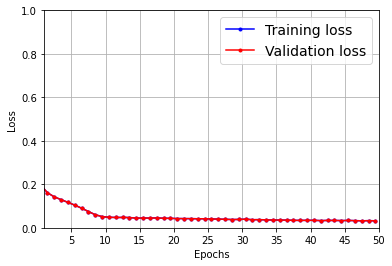

In [47]:
plot_learning_curves(history.history["loss"], history.history["val_loss"], epochs)
plt.show()

1069.5068305121529


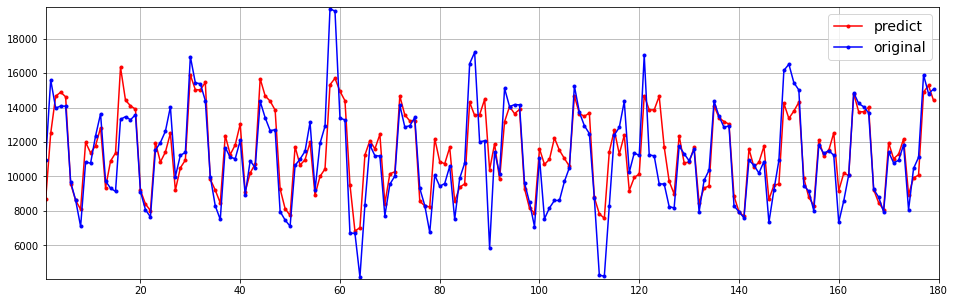

In [48]:
mae = GetResult_inverseTransfrom(X_test, Y_test, scaler_y, AutoRegression_model, target_size)

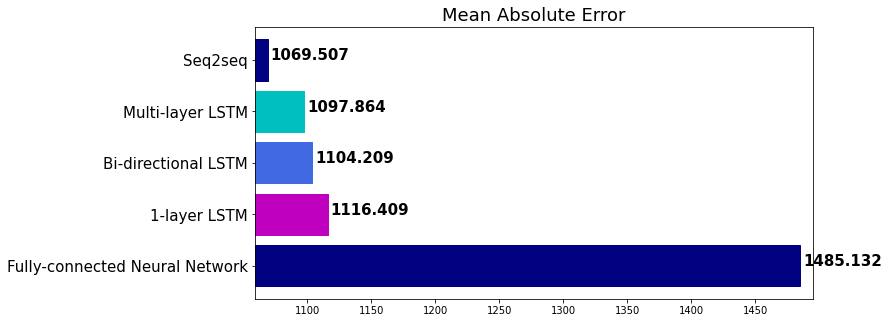

In [49]:
Graph_Evaluation(mae, 'Seq2seq')

## Dual-stage attention-based RNN (DA-RNN)

- A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction (2017, Qin, Yao, et al)
    - 342 citations

**Graphical illustration of DARNN**
<center><img src='pic/DARNN.png' width='1000'></center>  

In [50]:
interval = 30
m = 32       # encoder lstm unit length
p = 32       # decoder lstm unit length
n = 15        # number of features 
batch_size = 16
learning_rate = 0.001
epochs = 40

darnn = model_DARNN(df_train.drop(['Date'], axis=1), df_test.drop(['Date'], axis=1), interval, m, p, n, batch_size, learning_rate, epochs)

Shape of encoder input : (699, 30, 15)
Shape of decoder input : (699, 29, 1)
Shape of target input : (699,)
---------------------------------------
Shape of encoder input : (181, 30, 15)
Shape of decoder input : (181, 29, 1)
Shape of target input : (181,)


In [51]:
preds, labels, history_loss = darnn.createModel()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.19200405478477478
Epoch 2, Loss: 0.18892647325992584
Epoch 3, Loss: 0.18668104708194733
Epoch 4, Loss: 0.18569506704807281
Epoch 5, Loss: 0.18494658172130585
Epoch 6, Loss: 0.185684934258461
Epoch 7, Loss: 0.1851484775543213
Epoch 8, Loss: 0.1801399141550064
Epoch 9, Loss: 0.17883412539958954
Epoch 10, Loss: 0.17770379781723022
Epoch 11, Loss: 0.177408829331398
Epoch 12, Loss: 0.175911545753479
Epoch 13, Loss: 0.1721431463956833
Epoch 14, Loss: 0.17049366235733032
Epoch 15, Loss: 0.1649

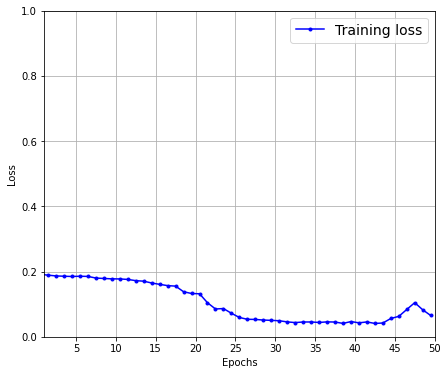

In [52]:
plot_learning_curves_train(history_loss, epochs)
plt.show()

In [53]:
labels_inverse = scaler_y.inverse_transform(labels.reshape(-1,1)).flatten()
preds_inverse = scaler_y.inverse_transform(preds.reshape(-1,1)).flatten()
preds_inverse = [0 if i < 0 else i for i in preds_inverse]

mae_darnn = mean_absolute_error(labels_inverse, preds_inverse)
mae_darnn

699.6203037283038

(1.0, 181.0, -100.0, 7079.35498046875)

(1.0, 181.0, -100.0, 7079.35498046875)

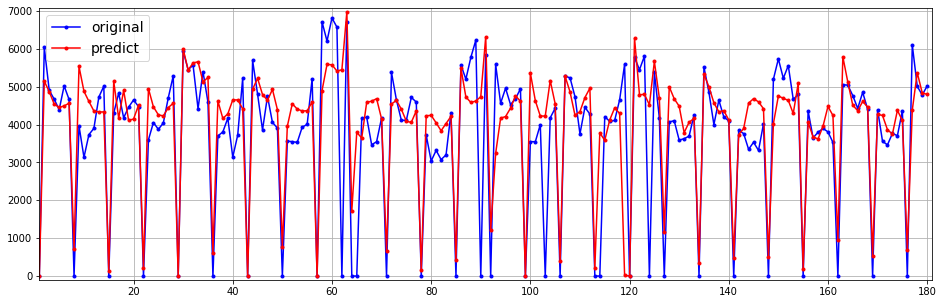

In [54]:
y_min = min(min(labels_inverse), min(preds_inverse))-100
y_max = max(max(labels_inverse), max(preds_inverse))+100

plt.rcParams["figure.figsize"] = (16, 5)

plt.plot(labels_inverse, 'b.-', label='original')
plt.axis([1, len(labels_inverse), y_min, y_max])
plt.legend(fontsize=14)
plt.grid(True)

plt.plot(preds_inverse, 'r.-', label='predict')
plt.axis([1, len(preds_inverse), y_min, y_max])
plt.legend(fontsize=14)

plt.show()

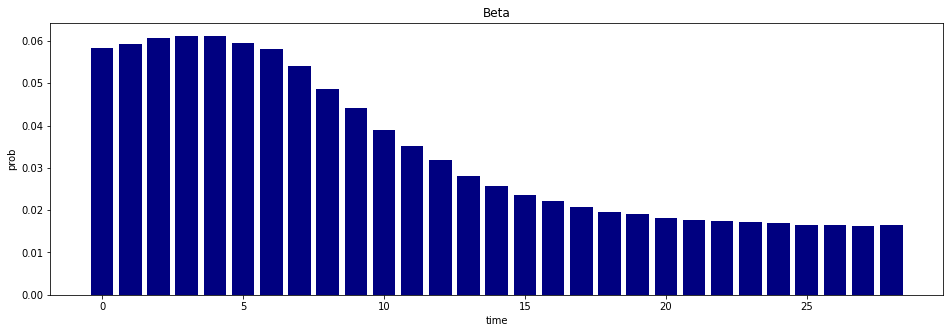

In [55]:
# Mean(coefficient) of temporal attention
darnn.coeff_TemporalAttention()

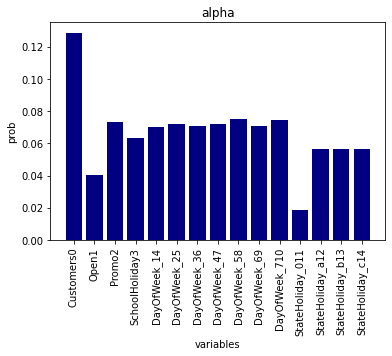

In [56]:
# Mean(coefficient) of Input Attention
variable_dict = {
            "Customers": ["0"],
            "Open": ["1"],
            "Promo": ["2"],
            "SchoolHoliday": ["3"],
            "DayOfWeek_1": ["4"],
            "DayOfWeek_2": ["5"],
            "DayOfWeek_3": ["6"],
            "DayOfWeek_4": ["7"],
            "DayOfWeek_5": ["8"],
            "DayOfWeek_6": ["9"],
            "DayOfWeek_7": ["10"],
            "StateHoliday_0": ["11"],
            "StateHoliday_a": ["12"],
            "StateHoliday_b": ["13"],
            "StateHoliday_c": ["14"]    
        }

darnn.coeff_InputAttention(variable_dict)

# 결과 리뷰 및 점검

- **과거 30일(t-30, t-29, ..., t-1) 판매량 관련 데이터를 이용하여, 이후 3일(t, t+1, t+2) 판매량 예측**
- 평가 : Mean Absolute Error
    - 3일간의 Sales 합 (발주량 예측)

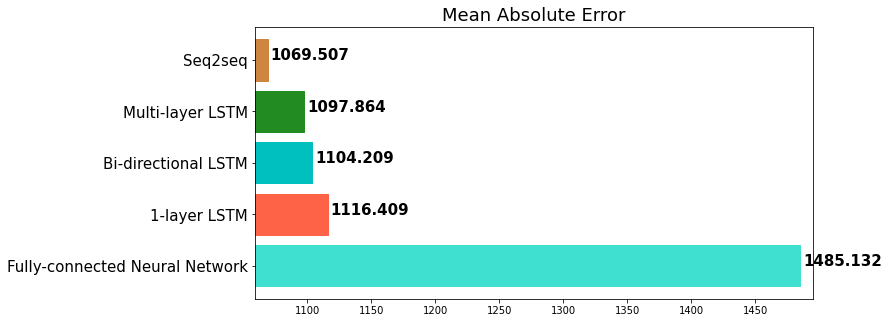

In [57]:
Graph_Evaluation(mae, 'Seq2seq')

- **과거 30일(t-30, t-29, ..., t-1) 판매량 관련 데이터를 이용하여, 다음 날(t) 판매량 예측**

In [58]:
mae_darnn

699.6203037283038